<img width="150" alt="Logo_ER10" src="https://user-images.githubusercontent.com/3244249/151994514-b584b984-a148-4ade-80ee-0f88b0aefa45.png">

### Model Interpretation using LIME for timeseries data
This notebook demonstrates the use of DIANNA with the LIME timeseries method on the coffee dataset.

LIME (Local Interpretable Model-agnostic Explanations) is an explainable-AI method that aims to create an interpretable model that locally represents the classifier. For more details see the [LIME paper](https://arxiv.org/abs/1602.04938).

*NOTE*: This tutorial is still work-in-progress, the final results need to be improved by tweaking the LIME parameters

In [1]:
import dianna
from pathlib import Path
import pandas as pd
import sklearn
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import accuracy_score as acc
import numpy as np

#### 1 - Loading the data

In [2]:
# Load coffee dataset
path_to_data = "data"
coffee_train = pd.read_csv(Path(path_to_data, "coffee_train.csv"),
                            sep=',', header=None).astype(float)
coffee_train_y = coffee_train.loc[:, 0]
coffee_train_x = coffee_train.loc[:, 1:]
coffee_test = pd.read_csv(Path(path_to_data, "coffee_test.csv"),
                           sep=',', header=None).astype(float)
coffee_test_y = coffee_test.loc[:, 0]
coffee_test_x = coffee_test.loc[:, 1:]

#### 2 - Define a KNN model to classify two types of coffee
Here we train a simple k-nearest neighbors (KNN) model for classification task.

In [3]:
# Define and train model
knn = KNN()
knn.fit(coffee_train_x, coffee_train_y)
print('Accuracy KNN for coffee dataset: %f' % (acc(coffee_test_y, knn.predict(coffee_test_x))))

Accuracy KNN for coffee dataset: 0.964286


An instance is selected for explanation.

In [4]:
# Select instance for explanation
idx = 5 # explained instance
num_features = 50 # how many feature contained in explanation
series = coffee_test_x.iloc[idx, :]
num_slices = len(series) # split time series

class_names = ['Arabica', 'Robusta']
labels = np.argsort(class_names)
series.shape

(286,)

Note that the LIME timeseries explainer in DIANNA can only receive input in the order of [timeseries, channels]. Given the way that the model was trained, we need to create an model runner for the explainer.

In [5]:
# the explainer must receive input in the order of [timeseries, channels]
data_instance = np.expand_dims(series, axis=1)
def run_model(data):
    data = data[:,:,0]
    return knn.predict_proba(data)

#### 3 - Applying LIME with DIANNA for timeseries

In this section we apply LIME to this KNN model to calculate the relevance score and visualize the results.

In [6]:
exp = dianna.explain_timeseries(run_model, timeseries_data=data_instance, method='lime',
                                labels=[0,1], class_names=class_names, num_features=num_features,
                                num_samples=500, num_slices=num_slices, distance_method='cosine')

/home/yangliu/miniconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Explaining: 100%|██████████| 500/500 [00:01<00:00, 260.35it/s]


Now we can visualize results using the built-in visualizer in `LIME` explainer. 

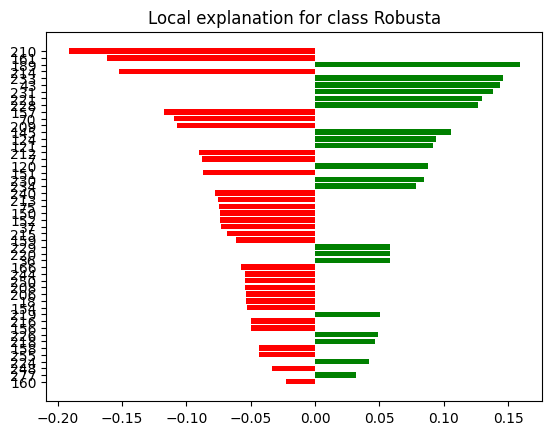

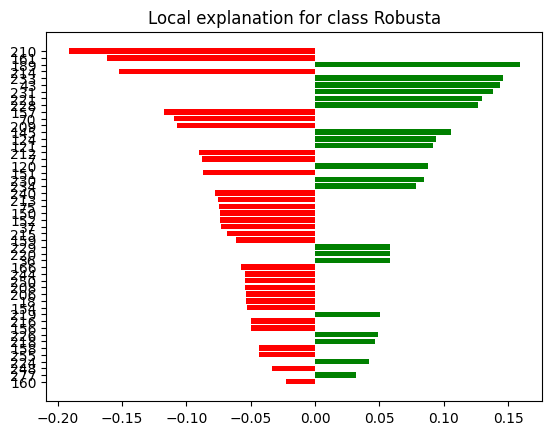

In [7]:
import matplotlib.pyplot as plt
exp.as_pyplot_figure()

TODO: use dianna visualization module to visualize the segmentation relevance chart.

1


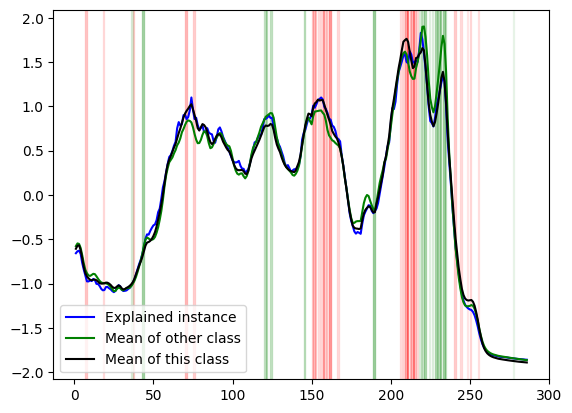

In [8]:
import math

values_per_slice = math.ceil(len(series) / num_slices)
print (values_per_slice)
plt.plot(series, color='b', label='Explained instance')
plt.plot(coffee_test_x.iloc[15:,:].mean(), color='green', label='Mean of other class')
plt.plot(coffee_test_x.iloc[:14,:].mean(), color='black', label='Mean of this class')
plt.legend(loc='lower left')

for i in range(num_features):
    feature, weight = exp.as_list()[i]
    start = feature * values_per_slice
    end = start + values_per_slice
    color = 'red' if weight < 0 else 'green' 
    plt.axvspan(start , end, color=color, alpha=abs(weight*2))
plt.show()

#### 4- Experiment with ONNX
DIANNA supports ONNX models. Here we demonstrate the use of LIME explainer for timeseries with a pre-trained ONNX model. <br>

The model is trained following this notebook: <br>
https://github.com/dianna-ai/dianna-exploration/blob/main/example_data/model_generation/coffee/generate_model.ipynb

In [10]:
from dianna.utils.onnx_runner import SimpleModelRunner

model_path = './models/coffee.onnx'
loaded_model = SimpleModelRunner(model_path)
coffee_train_x_numpy = coffee_train_x.to_numpy().astype(np.float32)
predictions = loaded_model(coffee_train_x_numpy)

A runner function is required since the model works with input in the order of [channels, timeseries], while LIME in DIANNA should receive input in the opposite order. 

In [11]:
import onnxruntime as ort

def run_model(data):
    # model must receive input in the order of [channels, timeseries]
    # get ONNX predictions
    predictions = []
    for i in range(data.shape[0]):
        input_data = data[i].T
        sess = ort.InferenceSession(model_path)
        input_name = sess.get_inputs()[0].name
        output_name = sess.get_outputs()[0].name

        onnx_input = {input_name: input_data.astype(np.float32)}
        pred_onnx = sess.run([output_name], onnx_input)[0]
        predictions.append(pred_onnx)
    
    return np.asarray(predictions)

Now we can call the explainer and visualize the results.

In [12]:
exp = dianna.explain_timeseries(run_model, timeseries_data=coffee_train_x_numpy.T, method='lime',
                                labels=[0, 1], class_names=class_names, num_features=num_features,
                                num_samples=500, num_slices=num_slices, batch_size=1, distance_method='cosine')

Explaining: 100%|██████████| 500/500 [00:01<00:00, 270.51it/s]


TODO: tweak the parameters and get sensible results.

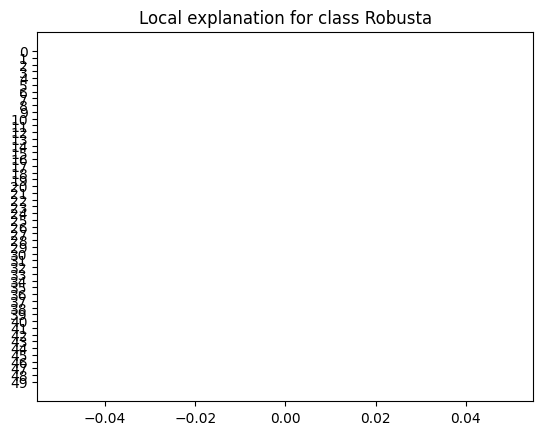

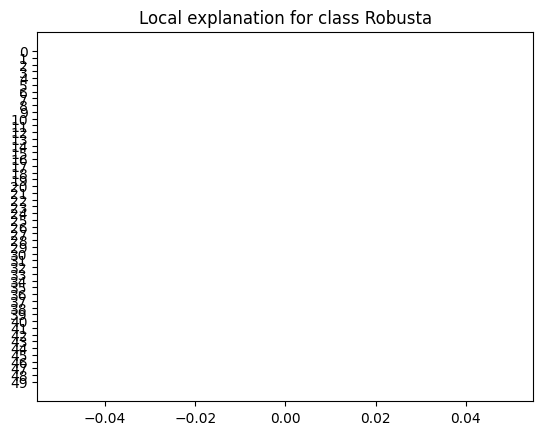

In [14]:
import matplotlib.pyplot as plt
exp.as_pyplot_figure()

1


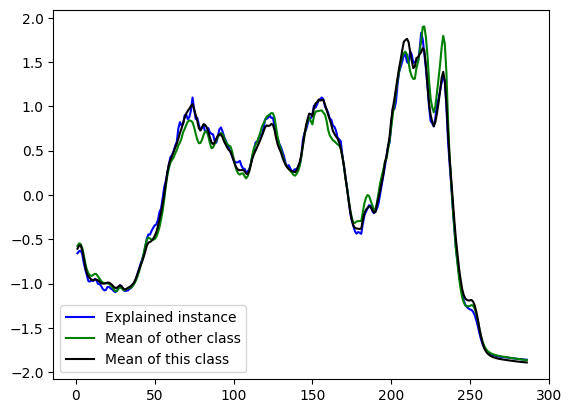

In [15]:
import math
values_per_slice = math.ceil(len(series) / num_slices)
print (values_per_slice)
plt.plot(series, color='b', label='Explained instance')
plt.plot(coffee_test_x.iloc[15:,:].mean(), color='green', label='Mean of other class')
plt.plot(coffee_test_x.iloc[:14,:].mean(), color='black', label='Mean of this class')
plt.legend(loc='lower left')

for i in range(num_features):
    feature, weight = exp.as_list()[i]
    start = feature * values_per_slice
    end = start + values_per_slice
    color = 'red' if weight < 0 else 'green' 
    plt.axvspan(start , end, color=color, alpha=abs(weight*2))
plt.show()

#### 5 - Conclusions
TODO: summarize the results and add conclusions to this notebook.